In [1]:
#%% import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from tf.transformations import quaternion_matrix, euler_from_matrix, euler_matrix

In [2]:
#%% Open HUB .npz
n_subjects = 5
subjects     = [0, 1, 2, 3, 4]
healthy_arm  = ['R', 'L', 'L', 'L', 'R']
# impaired_arm = ['L', 'R', 'R', 'R', 'L']

chain_R = ['Skeleton', 'Ab', 'Chest','RShoulder','RUArm','RFArm','RHand']
chain_L = ['Skeleton', 'Ab', 'Chest','LShoulder','LUArm','LFArm','LHand']
chain_H = ['Skeleton', 'Ab', 'Chest','Neck', 'Head']
cometh_chain = ['ground_pelvis', 'lumbar', 'thoracic_spine','scapulothoracic','GlenoHumeral','elbow','wrist']

cometh_dof_r = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending', 'thorax_extension', 'thorax_twist',\
                'scapula_r_abduction', 'scapula_r_elevation', 'scapula_r_upward_rot', 'shoulder_r_adduction', 'shoulder_r_flexion', 'shoulder_r_rotation', \
                'elbow_r_flexion', 'elbow_r_0', 'radioulnar_r_pro_sup', 'wrist_r_flexion', 'wrist_r_0', 'wrist_r_deviation']
cometh_dof_l = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending', 'thorax_extension', 'thorax_twist',\
                'scapula_l_abduction', 'scapula_l_elevation', 'scapula_l_upward_rot', 'shoulder_l_adduction', 'shoulder_l_flexion', 'shoulder_l_rotation', \
                'elbow_l_flexion', 'elbow_l_0', 'radioulnar_l_pro_sup', 'wrist_l_flexion', 'wrist_r_0', 'wrist_l_deviation']
cometh_dof =   ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending', 'thorax_extension', 'thorax_twist',\
                'scapula_abduction', 'scapula_elevation', 'scapula_upward_rot', 'shoulder_adduction', 'shoulder_flexion', 'shoulder_rotation', \
                'elbow_flexion', 'elbow_0', 'radioulnar_pro_sup', 'wrist_flexion', 'wrist_0', 'wrist_deviation']

subj_hub, subj_cometh, subj_cometh2 = {}, {}, {}

# # Load extracted angles from HUB and COMETH to match the file orders
def load_HUB_COMETH_data(s):
    HUB_folder = '../data/HUB_angles/'     
    COMETH_folder = '../data/COMETH/' 
    COMETH_folder_2 = '../data/COMETH_angles/'    
    side = healthy_arm[s]
    # find files with subject{s}_{side}h in the filename that exist in the HUB folder and COMETH folder
    files = [file for file in os.listdir(HUB_folder) if f'subject{s}_{side}h' in file and file.endswith('.angles_HUB.npz') 
             and os.path.exists(os.path.join(COMETH_folder, file.replace('.angles_HUB.npz', '.angles_COMETH.csv')))
             and os.path.exists(os.path.join(COMETH_folder_2, file.replace('.angles_HUB.npz', '.angles_COMETH.csv')))]
    
    filenames = [file.replace('.angles_HUB.npz', '') for file in files]
    print('\nSubject', s, 'filenames: ', filenames)

    if len(filenames) == 0:
        print(f'No files found for subject {s}')
        return None, None, None

    HUB_header = 'eul_right' if side == 'R' else 'eul_left'
    COMETH_header = cometh_dof_r if side == 'R' else cometh_dof_l

    time_frame = []
    for f, filename in enumerate(filenames):
        HUB_file = str(os.path.join(HUB_folder, filename + '.angles_HUB.npz'))
        COMETH_file = str(os.path.join(COMETH_folder, filename + '.angles_COMETH.csv'))
        COMETH_file_2 = str(os.path.join(COMETH_folder_2, filename + '.angles_COMETH.csv'))
        if f == 0:
            HUB_data = np.load(HUB_file)
            HUB_angles = HUB_data[HUB_header]
            time = HUB_data['time'] 
            
            COMETH_data = pd.read_csv(COMETH_file)
            COMETH_data_2 = pd.read_csv(COMETH_file_2)
        else:
            # HUB_data = np.concatenate((HUB_data, np.load(HUB_file)), axis=0)   
            HUB_data = np.load(HUB_file)
            HUB_angles = np.concatenate((HUB_angles, HUB_data[HUB_header]), axis=0)
            time = np.concatenate((time, HUB_data['time']+time[-1]+0.01), axis=0)

            COMETH_data = pd.concat([COMETH_data, pd.read_csv(COMETH_file)], axis=0)
            COMETH_data_2 = pd.concat([COMETH_data_2, pd.read_csv(COMETH_file_2)], axis=0)

        time_frame.append(time[-1,0])

    # print('\ntime', time.shape)
    # print('COMETH_data', COMETH_data.shape)
    # print('HUB_angles', HUB_angles.shape)

    subj_hub[s], subj_cometh[s], subj_cometh2[s] = {}, {}, {}
    subj_hub[s]['time'], subj_cometh[s]['time'], subj_cometh2[s]['time'] = time, time, time
    subj_hub[s]['time_frame'] = np.array(time_frame)
    # print('time_frame', time_frame)

    HUB_angles = HUB_angles.reshape(len(HUB_angles), 21).T
    for d, dof in enumerate(cometh_dof):
        subj_hub[s][dof] = HUB_angles[d] * 180/np.pi
    
        key = COMETH_header[d]
        if key in COMETH_data.columns:
            subj_cometh[s][dof] = np.array(COMETH_data[key] * 180/np.pi)
            subj_cometh2[s][dof] = np.array(COMETH_data_2[key] * 180/np.pi)
        else:
            subj_cometh[s][dof] = np.zeros(len(COMETH_data))
            subj_cometh2[s][dof] = np.zeros(len(COMETH_data))
            # print(f'Subject {s}:   {dof} not found in COMETH data')
    return subj_hub[s], subj_cometh[s], subj_cometh2[s]

# Print min and max values for each DoF
def print_joint_ranges(subjects=[0, 1, 2, 3, 4], subj_hub=subj_hub, subj_cometh=subj_cometh2):
    print("{:<5} {:<25} {:^15} {:^40} ".format("Subj", "", "COMETH", "UE_angle"))
    print("{:<5} {:<25} {:<10} {:<15} {:<10} {:<10}".format("#", "DoF", "min", "max", "min", "max"))
    for d, dof in enumerate(cometh_dof):
        for s in subjects:
            print("{:<5} {:<25} {:<10} {:<15} {:<10} {:<10}".format(s, dof, \
                    np.round(np.min(subj_cometh[s][dof]),2), np.round(np.max(subj_cometh[s][dof]),2), \
                    np.round(np.min(subj_hub[s][dof]),2), np.round(np.max(subj_hub[s][dof]),2)))
        if len(subjects)>1:
            print()

for s in subjects:
    subj_hub[s], subj_cometh[s], subj_cometh2[s] = load_HUB_COMETH_data(s)

print_joint_ranges([0, 2, 3, 4])

# # print(subj_hub[4].keys())
# # print(subj_hub[4]['pelvis_tilt'].shape)
# # print(subj_cometh[4].keys())
# # print(subj_cometh[4]['pelvis_tilt'].shape)
# print('HUB', subj_hub[4]['shoulder_rotation'][:30])
# print('COMETH', subj_cometh[4]['shoulder_rotation'][:30])


Subject 0 filenames:  ['subject0_Rh_free', 'subject0_Rh_clinical', 'subject0_Rh_clinical_WrPS']

Subject 1 filenames:  []
No files found for subject 1

Subject 2 filenames:  ['subject2_Lh_clinical_ShAAwithEl90', 'subject2_Lh_clinical', 'subject2_Lh_free']

Subject 3 filenames:  ['subject3_Lh_clinical', 'subject3_Lh_free']

Subject 4 filenames:  ['subject4_Rh_free', 'subject4_Rh_clinical']
Subj                                COMETH                      UE_angle                 
#     DoF                       min        max             min        max       
0     pelvis_tilt               -19.81     13.02           -11.6      20.04     
2     pelvis_tilt               -15.09     24.86           -12.52     35.34     
3     pelvis_tilt               5.18       29.58           -9.47      18.76     
4     pelvis_tilt               -34.55     19.64           -13.89     9.02      

0     pelvis_list               -18.95     35.99           -20.19     25.32     
2     pelvis_list             

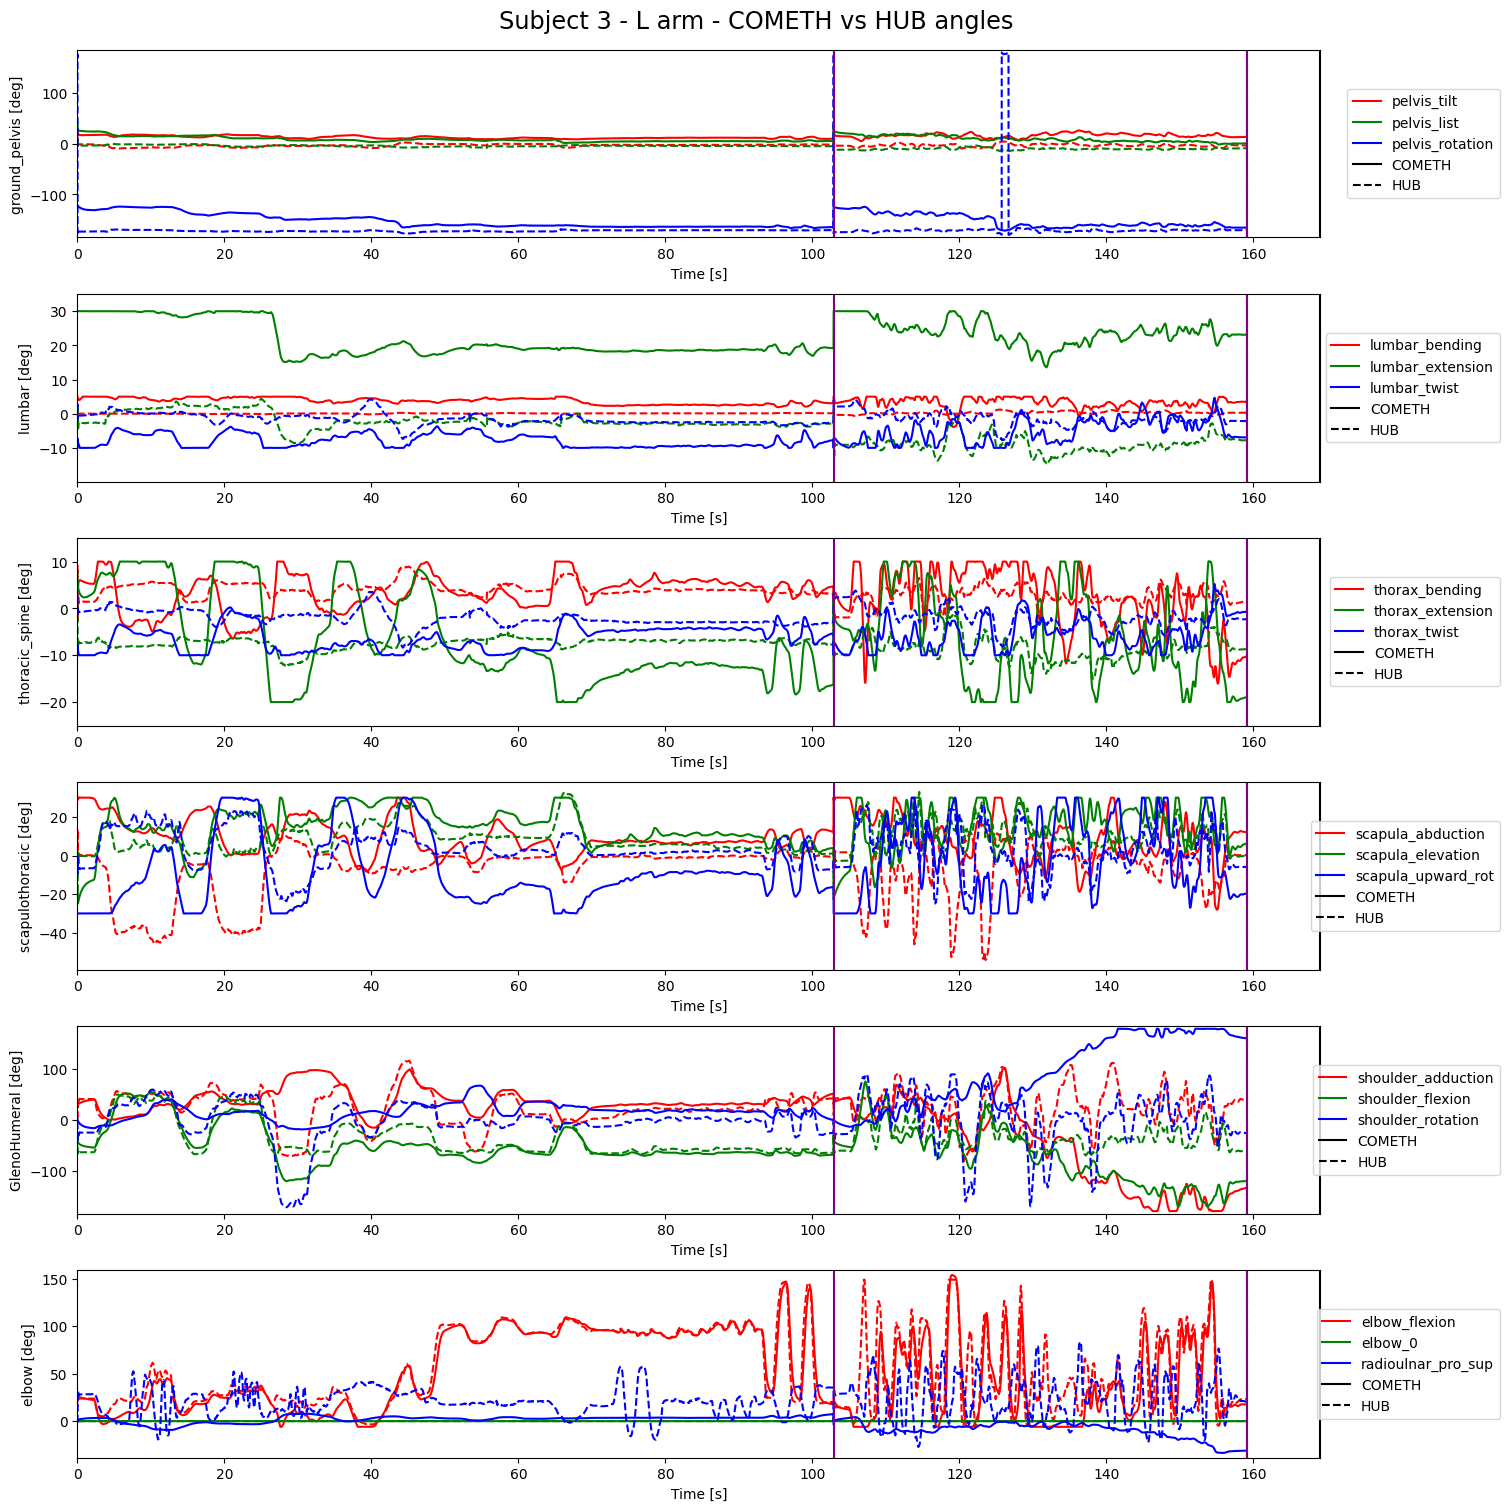

Error in callback <function flush_figures at 0x7fc51d58ea60> (for post_execute):


KeyboardInterrupt: 

In [3]:
#%% Plot angles vs time for each subject
# frame = np.arange(len(time))
# color_jax = ['r', 'g', 'b', 'r', 'g', 'b', 'k', 'r', 'g', 'b']

# cometh_chain = ['ground_pelvis', 'lumbar', 'thoracic_spine','scapulothoracic','GlenoHumeral','elbow','wrist']

# cometh_dof =   ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending', 'thorax_extension', 'thorax_twist',\
#                 'scapula_abduction', 'scapula_elevation', 'scapula_upward_rot', 'shoulder_adduction', 'shoulder_flexion', 'shoulder_rotation', \
#                 'elbow_flexion', 'elbow_0', 'radioulnar_pro_sup', 'wrist_flexion', 'wrist_0', 'wrist_deviation']

color_jax = ['r', 'g', 'b']

def plot_angles_vs_time(subjects=[0, 1, 2, 3, 4], joints=cometh_chain[:-1], dofs=None, method='subject', subj_hub=subj_hub, subj_cometh=subj_cometh2):
    if method == 'subject':
        n_ax = len(joints)
        for s in subjects:
            side = healthy_arm[s]
            fig_s, axs = plt.subplots(n_ax, 1, figsize=(15, n_ax*2.5), constrained_layout=True)
            fig_s.suptitle(f'Subject {s} - {side} arm - COMETH vs HUB angles', fontsize='xx-large')
            y_min , y_max = np.zeros(len(cometh_dof)), np.zeros(len(cometh_dof))
            # plot 3 DoFs of cometh_dof in each subplot
            for d, dof in enumerate(cometh_dof[:n_ax*3]):
                y_min[d] = np.min([subj_cometh[s][dof], subj_hub[s][dof]])
                y_max[d] = np.max([subj_cometh[s][dof], subj_hub[s][dof]])
                # print(dof_min, dof_max)
                n = int(d/3)
                axs[n].plot(subj_hub[s]['time'], subj_cometh[s][dof], color=color_jax[d%3], label=f'{dof}') #, label=f'{dof}_COMETH
                axs[n].plot(subj_hub[s]['time'], subj_hub[s][dof], linestyle='--', color=color_jax[d%3]) #, label=f'{dof}_HUB' 
            for n in range(n_ax):
                axs[n].set(xlabel='Time [s]', ylabel=f'{joints[n]} [deg]')
                axs[n].axvline(x=subj_hub[s]['time'][-1]+10, color='k', linestyle='-', label='COMETH')
                axs[n].axvline(x=subj_hub[s]['time'][-1], color='k', linestyle='--', label='HUB')
                axs[n].legend(bbox_to_anchor=(1.15, 0.5), fontsize='medium', loc='right') 
                axs[n].set(xlim=[0, subj_hub[s]['time'][-1]+10], ylim=[np.min(y_min[n*3:n*3+3])-5, np.max(y_max[n*3:n*3+3])+5])
                [axs[n].axvline(x=time_frame, color='purple', linestyle='-') for time_frame in subj_hub[s]['time_frame']]
                # axs[n].set_xlim([100, 170])
                # axs[n].set_xlim([0, 90])

    elif method == 'joints':
        for j, joint in enumerate(joints):
            n_ax = len(subjects)
            fig_j, axs = plt.subplots(n_ax, 1, figsize=(15, n_ax*2.5), constrained_layout=True)
            fig_j.suptitle(f'{joint} - COMETH vs HUB angles', fontsize='xx-large')
            y_min , y_max = np.zeros(len(subjects)), np.zeros(len(subjects))
            # plot 3 DoFs of cometh_dof in each subplot
            for s in subjects:
                for d, dof in enumerate(cometh_dof[j*3:j*3+3]):
                    y_min[s] = np.min([subj_cometh[s][dof], subj_hub[s][dof]])
                    y_max[s] = np.max([subj_cometh[s][dof], subj_hub[s][dof]])
                    print(y_min[s], y_max[s])
                    n = int(d/3)
                    axs[n].plot(subj_hub[s]['time'], subj_cometh[s][dof], color=color_jax[d%3], label=f'{dof}') #, label=f'{dof}_COMETH
                    axs[n].plot(subj_hub[s]['time'], subj_hub[s][dof], linestyle='--', color=color_jax[d%3]) #, label=f'{dof}_HUB'
                for n in range(n_ax):
                    axs[n].set(xlabel='Time [s]', ylabel=f'Subject {s} [deg]')
                    axs[n].axvline(x=subj_hub[s]['time'][-1]+10, color='k', linestyle='-', label='COMETH')
                    axs[n].axvline(x=subj_hub[s]['time'][-1], color='k', linestyle='--', label='HUB')
                    axs[n].legend(bbox_to_anchor=(1.15, 0.5), fontsize='medium', loc='right') 
                    axs[n].set(xlim=[0, subj_hub[s]['time'][-1]+10], ylim=[np.min(y_min)-5, np.max(y_max)+5])
                    axs[n].set_xlim([0, 150])
                    [axs[n].axvline(x=time_frame, color='purple', linestyle='-') for time_frame in subj_hub[s]['time_frame']]

    elif method == 'dofs':
        n_ax = len(dofs)
        for s in subjects:
            side = healthy_arm[s]
            fig_s, axs = plt.subplots(n_ax, 1, figsize=(15, n_ax*2.5), constrained_layout=True)
            fig_s.suptitle(f'Subject {s} - {side} arm - COMETH vs HUB angles', fontsize='xx-large')
            y_min , y_max = np.zeros(n_ax), np.zeros(n_ax)
            # plot each DoF of cometh_dof in each subplot
            for d, dof in enumerate(dofs):
                y_min[d] = np.min([subj_cometh[s][dof], subj_hub[s][dof]])
                y_max[d] = np.max([subj_cometh[s][dof], subj_hub[s][dof]])
                axs[d].plot(subj_hub[s]['time'], subj_cometh[s][dof], color=color_jax[d%3], label=f'{dof}')
                axs[d].plot(subj_hub[s]['time'], subj_hub[s][dof], linestyle='--', color=color_jax[d%3])
                axs[d].set(xlabel='Time [s]', ylabel=f'{dof} [deg]')
                axs[d].axvline(x=subj_hub[s]['time'][-1]+10, color='k', linestyle='-', label='COMETH')
                axs[d].axvline(x=subj_hub[s]['time'][-1], color='k', linestyle='--', label='HUB')
                axs[d].legend(bbox_to_anchor=(1.15, 0.5), fontsize='medium', loc='right')
                axs[d].set(xlim=[0, subj_hub[s]['time'][-1]+10], ylim=[np.min(y_min)-5, np.max(y_max)+5])
                [axs[d].axvline(x=time_frame, color='purple', linestyle='-') for time_frame in subj_hub[s]['time_frame']]
                axs[d].set_xlim([0, 150])

             
# plot_angles_vs_time(method='subject')
# plot_angles_vs_time(subjects=[3,4], subj_cometh=subj_cometh)
plot_angles_vs_time(subjects=[3,4], subj_cometh=subj_cometh2)
plot_angles_vs_time(method='dofs', subjects=[3,4], dofs=['shoulder_adduction', 'shoulder_flexion', 'shoulder_rotation', 'elbow_flexion'])
# plot_angles_vs_time(method='joints', joints=['GlenoHumeral', 'elbow', 'wrist'])


In [4]:
# #%% Plot angles vs eachother for each subject in a 2 by 3 figure
# subject_colors = ['b', 'r', 'g', 'c', 'm']
# # cometh_colors = ['k', 'k', 'k'
# pad = 5

# def plot_dof_comparison(d1, d2, figsize=(12, 10)):
#     fig_2d, ax_2d = plt.subplots(2, 3, figsize=figsize, num=f'all_vsCometh_{dof_names[d1]} vs {dof_names[d2]}') #, constrained_layout=True)
#     fig_2d.suptitle(f'{dof_names[d1]} vs {dof_names[d2]} for each subject', fontsize='xx-large')
#     big_ax = fig_2d.add_subplot(111, frameon=False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xlabel(f'{dof_names[d1]} (deg)', fontsize='x-large', labelpad=15)
#     big_ax.set_ylabel(f'{dof_names[d2]} (deg)', fontsize='x-large', labelpad=15)
#     for s in range(n_subjects):
#         ax_2d[s//3, s%3].scatter(eval(f"{dof_codes[d1]}_{s}"), eval(f"{dof_codes[d2]}_{s}"), label=f'UE_RoM_{s}', color=subject_colors[s], alpha=0.6)
#         ax_2d[s//3, s%3].scatter(eval(f"{cometh_dof[d1]}_{s}"), eval(f"{cometh_dof[d2]}_{s}"), label=f'COMETH_{s}', marker='x', color='gray', alpha=0.4)
#         ax_2d[1,2].scatter(eval(f"{dof_codes[d1]}_{s}"), eval(f"{dof_codes[d2]}_{s}"), label=f'subject {s}', color=subject_colors[s], alpha=1-s*0.2)
#         # ax_2d[1,2].scatter(eval(f"{cometh_dof[d1]}_{s}"), eval(f"{cometh_dof[d2]}_{s}"), label=f'subject {s}', marker='x', color='gray', alpha=0.4)
#     for i in range(2):
#         for j in range(3):
#             ax_2d[i,j].set(title=subject_labels[i*3+j], aspect='equal') #, xlim=(dof_min[d1]-pad, dof_max[d1]+pad), ylim=(dof_min[d2]-pad, dof_max[d2]+pad))
#             ax_2d[i,j].legend()
#     # fig_2d.savefig(f'../figures/vsCometh_{dof_names[d1]} vs {dof_names[d2]}.png')

# # ['cl_x', 'cl_y', 'cl_z', 'sh_abd', 'sh_rot', 'sh_ext', 'el_fle', 'el_sup', 'wr_dev', 'wr_sup', 'wr_fle']

# plot_dof_comparison(0, 1, figsize=(10, 4))     # Clav_x vs Clav_y
# plot_dof_comparison(0, 2, figsize=(10, 4.5))     # Clav_x vs Clav_z
# plot_dof_comparison(1, 2, figsize=(10, 8))     # Clav_y vs Clav_z
# plot_dof_comparison(3, 4, figsize=(10, 6))     # Shoulder Abduction vs Shoulder Rotation
# plot_dof_comparison(3, 5, figsize=(10, 7))     # Shoulder Abduction vs Shoulder Extension
# plot_dof_comparison(4, 5, figsize=(10, 8))     # Shoulder Rotation vs Shoulder Extension
# plot_dof_comparison(6, 3, figsize=(10, 8))     # Elbow Flexion vs Shoulder Abduction
# plot_dof_comparison(6, 4, figsize=(10, 7))      # Elbow Flexion vs Shoulder Rotation
# plot_dof_comparison(6, 5, figsize=(10, 8))     # Elbow Flexion vs Shoulder Extension
# plot_dof_comparison(6, 4, figsize=(10, 8))      # Elbow Flexion vs Elbow Supination
# # plot_dof_comparison(10, 8, figsize=(10, 5))    # Wrist Flexion vs Wrist Deviation



In [5]:
# #%% Plot angles over frame number for left arm
# frame = np.arange(len(time))

# # fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# # ax.plot(frame[:8000], L_cl_abd[:8000], label='UE_Clavicle abd')
# # ax.plot(frame[:8000], scapula_l_abduction[:8000], label='scapula_l_abduction')
# # ax.plot(frame[:8000], L_cl_rot[:8000], label='UE_Clavicle rot')
# # ax.plot(frame[:8000], scapula_l_upward_rot[:8000], label='scapula_l_upward_rot')
# # ax.plot(frame[:8000], L_cl_ext[:8000], label='UE_Clavicle ext')
# # ax.plot(frame[:8000], scapula_l_elevation[:8000], label='scapula_l_elevation')
# # ax.legend()

# # fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# # ax.plot(frame[:8000], L_sh_abd[:8000], label='UE_Shoulder abd')
# # ax.plot(frame[:8000], shoulder_l_adduction[:8000], label='shoulder_l_adduction')
# # ax.plot(frame[:8000], L_sh_rot[:8000], label='UE_Shoulder rot')
# # ax.plot(frame[:8000], shoulder_l_rotation[:8000], label='shoulder_l_rotation')
# # ax.plot(frame[:8000], L_sh_ext[:8000], label='UE_Shoulder ext')
# # ax.plot(frame[:8000], shoulder_l_flexion[:8000], label='shoulder_l_flexion')
# # ax.legend()

# fig, axs = plt.subplots(3, 1, figsize=(12, 8))
# # fig.suptitle('Left Upper Extremity angles')
# axs[0].plot(frame, L_cl_abd, label='UE_Clavicle abd')
# axs[0].plot(frame, scapula_l_abduction, label='scapula_l_abduction')
# axs[1].plot(frame, L_cl_rot, label='UE_Clavicle rot')
# axs[1].plot(frame, scapula_l_upward_rot, label='scapula_l_upward_rot')
# axs[2].plot(frame, L_cl_ext, label='UE_Clavicle ext')
# axs[2].plot(frame, scapula_l_elevation, label='scapula_l_elevation')
# for ax in axs:
#     ax.legend()
#     ax.grid()

# fig, axs = plt.subplots(3, 1, figsize=(12, 8))
# fig.suptitle('Left Shoulder angles')
# axs[0].plot(frame, L_sh_abd, label='UE_Shoulder abd')
# axs[0].plot(frame, shoulder_l_adduction, label='shoulder_l_adduction')
# axs[1].plot(frame, L_sh_rot, label='UE_Shoulder rot')
# axs[1].plot(frame, shoulder_l_rotation, label='shoulder_l_rotation')
# axs[2].plot(frame, L_sh_ext, label='UE_Shoulder ext')
# axs[2].plot(frame, shoulder_l_flexion, label='shoulder_l_flexion')
# for ax in axs:
#     ax.legend()
#     ax.grid()

# fig, axs = plt.subplots(2, 1, figsize=(12, 8))
# fig.suptitle('Left Elbow angles')
# axs[0].plot(frame, L_el_fle, label='UE_Elbow fle')
# axs[0].plot(frame, elbow_l_flexion, label='elbow_l_flexion')
# axs[1].plot(frame, L_el_sup, label='UE_Elbow sup')
# axs[1].plot(frame, radioulnar_l_pro_sup, label='radioulnar_l_pro_sup')
# for ax in axs:
#     ax.legend()
#     ax.grid()


In [6]:
# #%% Plot angles over frame number for right arm
# frame = np.arange(len(time))

# # fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# # ax.plot(frame[:8000], R_cl_abd[:8000], label='UE_Clavicle abd')
# # ax.plot(frame[:8000], scapula_r_abduction[:8000], label='scapula_r_abduction')
# # ax.plot(frame[:8000], R_cl_rot[:8000], label='UE_Clavicle rot')
# # ax.plot(frame[:8000], scapula_r_upward_rot[:8000], label='scapula_r_upward_rot')
# # ax.plot(frame[:8000], R_cl_ext[:8000], label='UE_Clavicle ext')
# # ax.plot(frame[:8000], scapula_r_elevation[:8000], label='scapula_r_elevation')
# # ax.legend()

# # fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# # ax.plot(frame[:8000], R_sh_abd[:8000], label='UE_Shoulder abd')
# # ax.plot(frame[:8000], shoulder_r_adduction[:8000], label='shoulder_r_adduction')
# # ax.plot(frame[:8000], R_sh_rot[:8000], label='UE_Shoulder rot')
# # ax.plot(frame[:8000], shoulder_r_rotation[:8000], label='shoulder_r_rotation')
# # ax.plot(frame[:8000], R_sh_ext[:8000], label='UE_Shoulder ext')
# # ax.plot(frame[:8000], shoulder_r_flexion[:8000], label='shoulder_r_flexion')
# # ax.legend()

# fig, axs = plt.subplots(3, 1, figsize=(12, 8))
# # fig.suptitle('Right Upper Extremity angles')
# axs[0].plot(frame, R_cl_abd, label='UE_Clavicle abd')
# axs[0].plot(frame, scapula_r_abduction, label='scapula_r_abduction')
# axs[1].plot(frame, R_cl_rot, label='UE_Clavicle rot')
# axs[1].plot(frame, scapula_r_upward_rot, label='scapula_r_upward_rot')
# axs[2].plot(frame, R_cl_ext, label='UE_Clavicle ext')
# axs[2].plot(frame, scapula_r_elevation, label='scapula_r_elevation')
# for ax in axs:
#     ax.legend()
#     ax.grid()

# fig, axs = plt.subplots(3, 1, figsize=(12, 8))
# fig.suptitle('Right Shoulder angles')
# axs[0].plot(frame, R_sh_abd, label='UE_Shoulder abd')
# axs[0].plot(frame, shoulder_r_adduction, label='shoulder_r_adduction')
# axs[1].plot(frame, R_sh_rot, label='UE_Shoulder rot')
# axs[1].plot(frame, shoulder_r_rotation, label='shoulder_r_rotation')
# axs[2].plot(frame, R_sh_ext, label='UE_Shoulder ext')
# axs[2].plot(frame, shoulder_r_flexion, label='shoulder_r_flexion')
# for ax in axs:
#     ax.legend()
#     ax.grid()

# fig, axs = plt.subplots(2, 1, figsize=(12, 8))
# fig.suptitle('Right Elbow angles')
# axs[0].plot(frame, R_el_fle, label='UE_Elbow fle')
# axs[0].plot(frame, elbow_r_flexion, label='elbow_r_flexion')
# axs[1].plot(frame, R_el_sup, label='UE_Elbow sup')
# axs[1].plot(frame, radioulnar_r_pro_sup, label='radioulnar_r_pro_sup')
# for ax in axs:
#     ax.legend()
#     ax.grid()

In [7]:
# # Draw Euler angles for left chain
# fig, axes = plt.subplots(len(chain_L), 3, figsize=(8, 16), constrained_layout=True, num='left_chain_angles')
# fig.suptitle('Left Chain Euler Angles', fontsize=14)
# for j in range(len(chain_L)):
#     eul_to_draw = eul_left[:, j] * 180/np.pi
#     # round to 2 decimal points
#     eul_to_draw = np.around(eul_to_draw, 2)
#     axes[j,0].scatter(eul_to_draw[:,0], eul_to_draw[:,1], label=f"{chain_L[j]}, 0, 1", marker='o', s=20, color='black')
#     axes[j,1].scatter(eul_to_draw[:,1], eul_to_draw[:,2], label=f"{chain_L[j]}, 1, 2", marker='o', s=20, color='black')
#     axes[j,2].scatter(eul_to_draw[:,2], eul_to_draw[:,0], label=f"{chain_L[j]}, 2, 0", marker='o', s=20, color='black')
#     axes[j,0].set(ylabel=(f"{chain_L[j]}, ax 0 vs 1"))
#     axes[j,1].set(ylabel=(f"{chain_L[j]}, ax 1 vs 2"))
#     axes[j,2].set(ylabel=(f"{chain_L[j]}, ax 2 vs 0"))

# # Draw Euler angles for left upper limb
# sc_abd = np.around(eul_left[:,3,0] * 180/np.pi)
# sc_rot = np.around(eul_left[:,3,1] * 180/np.pi)
# sc_ext = np.around(eul_left[:,3,2] * 180/np.pi)
# sh_rot = np.around(eul_left[:,4,1] * 180/np.pi)
# sh_abd = np.around(eul_left[:,4,0] * 180/np.pi)
# sh_ext = np.around(eul_left[:,4,2] * 180/np.pi)
# el_fle = np.around(eul_left[:,5,0] * 180/np.pi)
# el_sup = np.around(eul_left[:,5,1] * 180/np.pi)

# joint_names = ['Hip', 'Abdomen', 'Chest', 'Scapula', 'Shoulder', 'Elbow', 'Wrist']
# # eul_left.shape = (n, 7, 3)
# print("{:<20} {:<10} {:<10} {:<10}".format("Joint:", "xyz", "min", "max"))
# for j in range(3, len(chain_R)):
#     print()
#     for k in range(3):
#         eul_min = min(eul_left[:,j,k]) * 180/np.pi
#         eul_max = max(eul_left[:,j,k]) * 180/np.pi
#         print("{:<20} {:<10} {:<10} {:<10}".format('R_' + joint_names[j], k, str(np.around(eul_min, 2)), str(np.around(eul_max, 2))))
# print('\n\n')

# fig2, axes2 = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True, num='left_arm_angles')
# fig2.suptitle('Left Upper Limb Euler Angles', fontsize=14, y=0.96)
# fig2.subplots_adjust(wspace=0.5, hspace=0.4)
# axes2[0,0].scatter(sh_rot[:], sh_abd[:], marker='o', s=10, color='blue')
# axes2[0,0].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Abduction (deg)')
# axes2[0,1].scatter(sh_rot[:], sh_ext[:], marker='o', s=10, color='blue')
# axes2[0,1].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Extension (deg)')
# axes2[0,2].scatter(sh_abd[:], sh_ext[:], marker='o', s=10, color='blue')
# axes2[0,2].set(xlabel='Shoulder Abduction (deg)', ylabel='Shoulder Extension (deg)')
# axes2[1,0].scatter(el_fle[:], sh_rot[:], marker='o', s=10, color='blue')
# axes2[1,0].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Rotation (deg)')
# axes2[1,1].scatter(el_fle[:], sh_abd[:], marker='o', s=10, color='blue')
# axes2[1,1].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Abduction (deg)')
# axes2[1,2].scatter(el_fle[:], sh_ext[:], marker='o', s=10, color='blue')
# axes2[1,2].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Extension (deg)')

# # Draw Euler angles for shoulder and scapula
# fig3, axes3 = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True, num='left_shoulder_angles')
# fig3.suptitle('Left Shoulder and Scapula Euler Angles', fontsize=14, y=0.96)
# fig3.subplots_adjust(wspace=0.5, hspace=0.4)
# axes3[0,0].scatter(sc_abd[:], sh_abd[:], marker='o', s=10, color='blue')
# axes3[0,0].set(xlabel='Scapula Abduction (deg)', ylabel='Shoulder Abduction (deg)')
# axes3[0,1].scatter(sc_abd[:], sh_rot[:], marker='o', s=10, color='blue')
# axes3[0,1].set(xlabel='Scapula Abduction (deg)', ylabel='Shoulder Rotation (deg)')
# axes3[0,2].scatter(sc_abd[:], sh_ext[:], marker='o', s=10, color='blue')
# axes3[0,2].set(xlabel='Scapula Abduction (deg)', ylabel='Shoulder Extension (deg)')
# axes3[1,0].scatter(sc_rot[:], sh_abd[:], marker='o', s=10, color='blue')
# axes3[1,0].set(xlabel='Scapula Rotation (deg)', ylabel='Shoulder Abduction (deg)')
# axes3[1,1].scatter(sc_rot[:], sh_rot[:], marker='o', s=10, color='blue')
# axes3[1,1].set(xlabel='Scapula Rotation (deg)', ylabel='Shoulder Rotation (deg)')
# axes3[1,2].scatter(sc_rot[:], sh_ext[:], marker='o', s=10, color='blue')
# axes3[1,2].set(xlabel='Scapula Rotation (deg)', ylabel='Shoulder Extension (deg)')
# axes3[2,0].scatter(sc_ext[:], sh_abd[:], marker='o', s=10, color='blue')
# axes3[2,0].set(xlabel='Scapula Extension (deg)', ylabel='Shoulder Abduction (deg)')
# axes3[2,1].scatter(sc_ext[:], sh_rot[:], marker='o', s=10, color='blue')
# axes3[2,1].set(xlabel='Scapula Extension (deg)', ylabel='Shoulder Rotation (deg)')
# axes3[2,2].scatter(sc_ext[:], sh_ext[:], marker='o', s=10, color='blue')
# axes3[2,2].set(xlabel='Scapula Extension (deg)', ylabel='Shoulder Extension (deg)')


# # save figures with csv file name
# # fig.savefig(f'../data/figures/{npz_file.split("/")[-1].split("_")[0]}_left_chain_angles.png')
# # fig2.savefig(f'../data/figures/{npz_file.split("/")[-1].split("_")[0]}_left_arm_angles.png')

# plt.show()

In [8]:
# #%% Draw Euler angles for right chain
# fig, axes = plt.subplots(len(chain_R), 3, figsize=(8, 16), constrained_layout=True, num='right_chain_angles')
# fig.suptitle('Right Chain Euler Angles', fontsize=14)
# for j in range(len(chain_R)):
#     eul_to_draw = eul_right[:, j] * 180/np.pi
#     # round to 2 decimal points
#     eul_to_draw = np.around(eul_to_draw, 2)
#     # axes[j,0].scatter(eul_to_draw[:len(time_cl),0], eul_to_draw[:len(time_cl),1], label=f"{chain_R[j]}, 0, 1", marker='o', s=20, color='black')
#     # axes[j,0].scatter(eul_to_draw[len(time_cl):,0], eul_to_draw[len(time_cl):,1], label=f"{chain_R[j]}, 0, 1", marker='o', s=20, color='blue')
#     axes[j,0].scatter(eul_to_draw[:,0], eul_to_draw[:,1], label=f"{chain_R[j]}, 0, 1", marker='o', s=20, color='black')
#     axes[j,1].scatter(eul_to_draw[:,1], eul_to_draw[:,2], label=f"{chain_R[j]}, 1, 2", marker='o', s=20, color='black')
#     axes[j,2].scatter(eul_to_draw[:,2], eul_to_draw[:,0], label=f"{chain_R[j]}, 2, 0", marker='o', s=20, color='black')
#     axes[j,0].set(ylabel=(f"{chain_R[j]}, ax 0 vs 1"))
#     axes[j,1].set(ylabel=(f"{chain_R[j]}, ax 1 vs 2"))
#     axes[j,2].set(ylabel=(f"{chain_R[j]}, ax 2 vs 0"))

# # Draw Euler angles for right upper limb
# sc_abd = np.around(eul_right[:,3,0] * 180/np.pi)
# sc_rot = np.around(eul_right[:,3,1] * 180/np.pi)
# sc_ext = np.around(eul_right[:,3,2] * 180/np.pi)
# sh_rot = np.around(eul_right[:,4,1] * 180/np.pi)
# sh_abd = np.around(eul_right[:,4,0] * 180/np.pi)
# sh_ext = np.around(eul_right[:,4,2] * 180/np.pi)
# el_fle = np.around(eul_right[:,5,0] * 180/np.pi)
# el_sup = np.around(eul_right[:,5,1] * 180/np.pi)

# joint_names = ['Hip', 'Abdomen', 'Chest', 'Scapula', 'Shoulder', 'Elbow', 'Wrist']
# # eul_left.shape = (n, 7, 3)
# print("{:<20} {:<10} {:<10} {:<10}".format("Joint:", "xyz", "min", "max"))
# for j in range(3, len(chain_R)):
#     print()
#     for k in range(3):
#         eul_min = min(eul_right[:,j,k]) * 180/np.pi
#         eul_max = max(eul_right[:,j,k]) * 180/np.pi
#         print("{:<20} {:<10} {:<10} {:<10}".format('R_' + joint_names[j], k, str(np.around(eul_min, 2)), str(np.around(eul_max, 2))))
# print('\n\n')

# fig2, axes2 = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True, num='right_arm_angles')
# fig2.suptitle('Right Upper Limb Euler Angles', fontsize=14, y=0.96)
# fig2.subplots_adjust(wspace=0.5, hspace=0.4)

# axes2[0,0].scatter(sh_rot[:], sh_abd[:], marker='o', s=10, color='blue')
# axes2[0,0].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Abduction (deg)')
# axes2[0,1].scatter(sh_rot[:], sh_ext[:], marker='o', s=10, color='blue')
# axes2[0,1].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Extension (deg)')
# axes2[0,2].scatter(sh_abd[:], sh_ext[:], marker='o', s=10, color='blue')
# axes2[0,2].set(xlabel='Shoulder Abduction (deg)', ylabel='Shoulder Extension (deg)')

# axes2[1,0].scatter(el_fle[:], sh_rot[:], marker='o', s=10, color='blue')
# axes2[1,0].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Rotation (deg)')
# axes2[1,1].scatter(el_fle[:], sh_abd[:], marker='o', s=10, color='blue')
# axes2[1,1].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Abduction (deg)')
# axes2[1,2].scatter(el_fle[:], sh_ext[:], marker='o', s=10, color='blue')
# axes2[1,2].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Extension (deg)')

# # Draw Euler angles for shoulder and scapula
# fig3, axes3 = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True, num='left_shoulder_angles')
# fig3.suptitle('Left Shoulder and Scapula Euler Angles', fontsize=14, y=0.96)
# fig3.subplots_adjust(wspace=0.5, hspace=0.4)
# axes3[0,0].scatter(sc_abd[:], sh_abd[:], marker='o', s=10, color='blue')
# axes3[0,0].set(xlabel='Scapula Abduction (deg)', ylabel='Shoulder Abduction (deg)')
# axes3[0,1].scatter(sc_abd[:], sh_rot[:], marker='o', s=10, color='blue')
# axes3[0,1].set(xlabel='Scapula Abduction (deg)', ylabel='Shoulder Rotation (deg)')
# axes3[0,2].scatter(sc_abd[:], sh_ext[:], marker='o', s=10, color='blue')
# axes3[0,2].set(xlabel='Scapula Abduction (deg)', ylabel='Shoulder Extension (deg)')
# axes3[1,0].scatter(sc_rot[:], sh_abd[:], marker='o', s=10, color='blue')
# axes3[1,0].set(xlabel='Scapula Rotation (deg)', ylabel='Shoulder Abduction (deg)')
# axes3[1,1].scatter(sc_rot[:], sh_rot[:], marker='o', s=10, color='blue')
# axes3[1,1].set(xlabel='Scapula Rotation (deg)', ylabel='Shoulder Rotation (deg)')
# axes3[1,2].scatter(sc_rot[:], sh_ext[:], marker='o', s=10, color='blue')
# axes3[1,2].set(xlabel='Scapula Rotation (deg)', ylabel='Shoulder Extension (deg)')
# axes3[2,0].scatter(sc_ext[:], sh_abd[:], marker='o', s=10, color='blue')
# axes3[2,0].set(xlabel='Scapula Extension (deg)', ylabel='Shoulder Abduction (deg)')
# axes3[2,1].scatter(sc_ext[:], sh_rot[:], marker='o', s=10, color='blue')
# axes3[2,1].set(xlabel='Scapula Extension (deg)', ylabel='Shoulder Rotation (deg)')
# axes3[2,2].scatter(sc_ext[:], sh_ext[:], marker='o', s=10, color='blue')
# axes3[2,2].set(xlabel='Scapula Extension (deg)', ylabel='Shoulder Extension (deg)')

# # save figures with csv file name
# fig.savefig(f'../data/figures/{npz_file.split("/")[-1].split("_")[0]}_right_chain_angles.png')
# fig2.savefig(f'../data/figures/{npz_file.split("/")[-1].split("_")[0]}_right_arm_angles.png')

# plt.show()

In [9]:
# #%% Visualization of joint locations at time t
# t = 10000
# eul_seq = 'rzxy'

# # Offset angle between strnm_dir_R/L and strnm_dir_H
# strnm_dir_R = skl_R[('RShoulder', 'Position')] - skl_R[('Chest', 'Position')]
# strnm_dir_L = skl_L[('LShoulder', 'Position')] - skl_L[('Chest', 'Position')]
# strnm_dir_H = skl_H[('Neck', 'Position')] - skl_H[('Chest', 'Position')]
# strnm_ang_R = np.arccos(np.dot(strnm_dir_R.iloc[t], strnm_dir_H.iloc[t])/(np.linalg.norm(strnm_dir_R.iloc[t])*np.linalg.norm(strnm_dir_H.iloc[t])))
# strnm_ang_L = np.arccos(np.dot(strnm_dir_L.iloc[t], strnm_dir_H.iloc[t])/(np.linalg.norm(strnm_dir_L.iloc[t])*np.linalg.norm(strnm_dir_H.iloc[t])))

# def get_positions(skl, chain):  
#     positions = []
#     for j in range(len(chain)):
#         pos = skl[(chain[j], 'Position')].iloc[t]
#         positions.append(np.array(pos))
#     return positions - positions[0]

# def get_euler(skl, chain):  
#     eul = []
#     R_prox = np.eye(3)
#     for j in range(len(chain)):
#         q = skl[(chain[j], 'Rotation')].iloc[t]
#         R_global = quaternion_matrix(q)[:3,:3]
#         R_rel = R_prox.T @ R_global
#         R_prox = R_global
#         eul_values = euler_from_matrix(R_rel, axes=eul_seq)
#         # (ang1, ang2, ang3) = euler_from_matrix(R_rel, axes=eul_seq)
#         # eul_values = np.array([ang1, ang2, ang3])
#         eul.append(eul_values)
#     return np.array(eul)

# def forward_kinematics(skl, chain): 
#     bone_pos = get_positions(skl, chain)
#     bone_length = np.linalg.norm(np.diff(bone_pos, axis=0), axis=1)
#     eul_angles = get_euler(skl, chain)
    
#     fk_pose = np.zeros((len(eul_angles), 3))
#     pos_prox = np.zeros(3)
#     R_prox = np.eye(3)
#     fk_pose[0] = bone_pos[0]
#     for i in range(2):
#         R_rel = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
#         R_prox = R_prox @ R_rel
#         pos_prox += R_prox @ np.array([0, 0, bone_length[i]])
#         fk_pose[i+1] = pos_prox

#     for i in range(2, len(eul_angles)-1):
#         R_rel = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
#         R_prox = R_prox @ R_rel
#         if chain==chain_R:  
#             if i==2:
#                 R_off = euler_matrix(0, 0, strnm_ang_R, axes='szxy')[:3, :3]
#                 pos_prox += R_prox @ R_off @ np.array([0, 0, bone_length[i]])
#             else:
#                 pos_prox += R_prox @ np.array([bone_length[i], 0, 0])
#         elif chain==chain_L:
#             if i==2:
#                 R_off = euler_matrix(0, 0, -strnm_ang_L, axes='szxy')[:3, :3]
#                 pos_prox += R_prox @ R_off @ np.array([0, 0, bone_length[i]])
#             else:
#                 pos_prox += R_prox @ np.array([-bone_length[i], 0, 0])
#         elif chain==chain_H:
#             pos_prox += R_prox @ np.array([0, 0, bone_length[i]])
#         fk_pose[i+1] = pos_prox
#     return fk_pose

# # Get bone positions from raw data
# pos_raw_R = get_positions(skl_R, chain_R)
# pos_raw_L = get_positions(skl_L, chain_L)
# pos_raw_H = get_positions(skl_H, chain_H)

# # Get bone positions using forward kinematics
# pos_fk_R = forward_kinematics(skl_R, chain_R)
# pos_fk_L = forward_kinematics(skl_L, chain_L)
# pos_fk_H = forward_kinematics(skl_H, chain_H)

# eul_angles_R = get_euler(skl_R, chain_R)
# eul_angles_L = get_euler(skl_L, chain_L)
# eul_angles_H = get_euler(skl_H, chain_H)

# print("{:<10} {:<25} {:<25} {:<25}".format("pos_R:", "Raw", "FK", "Euler Angles"))
# for j in range(len(chain_R)):
#     print("{:<10} {:<25} {:<25} {:<25}".format(chain_R[j], str(np.around(pos_raw_R[j], 2)), str(np.around(pos_fk_R[j], 2)), str(np.around(eul_angles_R[j]*180/np.pi, 2))))
# print("{:<10} {:<25} {:<25} {:<25}".format("pos_L:", "Raw", "FK", "Euler Angles"))
# for j in range(len(chain_L)):
#     print("{:<10} {:<25} {:<25} {:<25}".format(chain_L[j], str(np.around(pos_raw_L[j], 2)), str(np.around(pos_fk_L[j], 2)), str(np.around(eul_angles_L[j]*180/np.pi, 2))))        
# for j in range(len(chain_H)):
#     print("{:<10} {:<25} {:<25} {:<25}".format(chain_H[j], str(np.around(pos_raw_H[j], 2)), str(np.around(pos_fk_H[j], 2)), str(np.around(eul_angles_H[j]*180/np.pi, 2))))

# # Plot positions using raw position data and forward kinematics
# fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(11, 4.5), constrained_layout=True, num='Joint Locations')
# # fig.subplots_adjust(left=-0.5, wspace=0.08, right=1.2)
# for ax in axes:
#     ax.set(xlabel='X', ylabel='Y', zlabel='Z', xlim=(-500, 500), ylim=(-500, 500), zlim=(-100, 900))
#     ax.view_init(elev=25, azim=150)
# ax1, ax2 = axes[0], axes[1]
# ax1.set_title('Joint Locations Using Position Data', pad=8)
# ax2.set_title('Joint Locations Using Forward Kinematics', pad=8)
# # colors = ['k', 'y', 'm', 'c', 'r', 'g', 'b']
# colors_R = ['black', 'orange', 'navy', 'cyan', 'red', 'green', 'blue']
# colors_L = ['black', 'orange', 'navy', 'purple', 'magenta', 'lime', 'teal']
# for j in range(len(chain_R)):
#     ax1.scatter(pos_raw_R[j][0], pos_raw_R[j][1], pos_raw_R[j][2], label=f"{chain_R[j]}, Raw", marker='*', s=50, color=colors_R[j])
#     ax1.scatter(pos_raw_L[j][0], pos_raw_L[j][1], pos_raw_L[j][2], label=f"{chain_L[j]}, Raw", marker='*', s=50, color=colors_L[j])
#     ax2.scatter(pos_fk_R[j][0], pos_fk_R[j][1], pos_fk_R[j][2], label=f"{chain_R[j]}, FK", marker='o', s=50, color=colors_R[j])
#     ax2.scatter(pos_fk_L[j][0], pos_fk_L[j][1], pos_fk_L[j][2], label=f"{chain_L[j]}, FK", marker='o', s=50, color=colors_L[j])
#     if j!=0:
#         ax1.plot([pos_raw_R[j][0], pos_raw_R[j-1][0]], [pos_raw_R[j][1], pos_raw_R[j-1][1]], [pos_raw_R[j][2], pos_raw_R[j-1][2]], 'k')
#         ax1.plot([pos_raw_L[j][0], pos_raw_L[j-1][0]], [pos_raw_L[j][1], pos_raw_L[j-1][1]], [pos_raw_L[j][2], pos_raw_L[j-1][2]], 'b')
#         ax2.plot([pos_fk_R[j][0], pos_fk_R[j-1][0]], [pos_fk_R[j][1], pos_fk_R[j-1][1]], [pos_fk_R[j][2], pos_fk_R[j-1][2]], 'k')
#         ax2.plot([pos_fk_L[j][0], pos_fk_L[j-1][0]], [pos_fk_L[j][1], pos_fk_L[j-1][1]], [pos_fk_L[j][2], pos_fk_L[j-1][2]], 'b')
# for j in range(1, len(chain_H)):
#     ax1.scatter(pos_raw_H[j][0], pos_raw_H[j][1], pos_raw_H[j][2], label=f"{chain_H[j]}, Raw", marker='*', s=50, color='black')
#     ax2.scatter(pos_fk_H[j][0], pos_fk_H[j][1], pos_fk_H[j][2], label=f"{chain_H[j]}, FK", marker='o', s=50, color='black')
#     if j!=0:
#         ax1.plot([pos_raw_H[j][0], pos_raw_H[j-1][0]], [pos_raw_H[j][1], pos_raw_H[j-1][1]], [pos_raw_H[j][2], pos_raw_H[j-1][2]], 'k--')
#         ax2.plot([pos_fk_H[j][0], pos_fk_H[j-1][0]], [pos_fk_H[j][1], pos_fk_H[j-1][1]], [pos_fk_H[j][2], pos_fk_H[j-1][2]], 'k--')
# ax2.legend(handles=
#     [Line2D([],[], color=colors_R[j], linestyle='', marker='o', markersize=8, label=f"{chain_R[j]}") for j in range(len(chain_R))] + 
#     [Line2D([],[], color=colors_L[j], linestyle='', marker='o', markersize=8, label=f"{chain_L[j]}") for j in range(3, len(chain_L))] + 
#     [Line2D([],[], color='black', linestyle='-', label='Bones')],  loc='right', bbox_to_anchor=(1.4, 0.5))
# plt.show()
